In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.510387 seconds (14.89 M allocations: 957.793 MiB, 11.93% gc time, 99.28% compilation time: <1% of which was recompilation)


In [2]:
using QuantumOptics
import PyPlot
const plt = PyPlot;
using Random, Distributions
using ProgressBars
using DelimitedFiles
Random.seed!(0)


TaskLocalRNG()

Some useful globals

In [88]:
########## Calcium-40 ion ##########
CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])

########## Some calibrated values for the Molmer-sorensen gate ##########

μ_I = 94326.65907221894 # laser-intensity, W/cm^2
μ_ν = 2.5e5 # trap-frequency, Hz
μ_f_cl = 4.111550352057269e14 # laser-frequency, Hz
μ_ϕ = 0.0 # relative phase between red and blue sidebands 
MS_π2_TIME = 1e-4 # gate-time for an MS(π/2) gate
AC_CORRECTION = 0 # ac-stark shift correction, Hz
B_STRENGTH = 6e-4 # magnetic field strength, T

########## Some useful quantum states ##########

# Computational basis
ket_00 = CALCIUM40["S"] ⊗ CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ⊗ CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ⊗ CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ⊗ CALCIUM40["D"]
ρ_00 = dm(ket_00)
ρ_01 = dm(ket_01)
ρ_10 = dm(ket_10)
ρ_11 = dm(ket_11)

# Bell basis
ket_00_m_i11 = (ket_00 - 1im*ket_11)/√2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/√2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/√2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/√2
ρ_00_m_i11 = dm(ket_00_m_i11)
ρ_00_p_i11 = dm(ket_00_p_i11)
ρ_01_m_i10 = dm(ket_01_m_i10)
ρ_01_p_i10 = dm(ket_01_p_i10);


Helper function for plotting state populations

In [106]:
function plot_populations(chamber, tout, sol)

    ket0_vib_mode = IonSim.modes(chamber)[1][0]
    dm0_vib_mode = dm(ket0_vib_mode)

    # compute expectation values
    prob_00 = expect(ρ_00 ⊗ dm0_vib_mode , sol)  # 𝔼(|S⟩|S⟩)
    prob_11 = expect(ρ_11 ⊗ dm0_vib_mode, sol)  # 𝔼(|D⟩|D⟩)
    prob_01 = expect(ρ_01 ⊗ dm0_vib_mode, sol)  # 𝔼(|S⟩|D⟩)
    prob_10 = expect(ρ_10 ⊗ dm0_vib_mode, sol)  # 𝔼(|D⟩|S⟩)
    prob_00_p_i11 = expect(ρ_00_p_i11 ⊗ dm0_vib_mode, sol)  # 𝔼(|S⟩|S⟩ + i|D⟩|D⟩)
    prob_00_m_i11 = expect(ρ_00_m_i11 ⊗ dm0_vib_mode, sol)  # 𝔼(|S⟩|S⟩ - i|D⟩|D⟩)
    prob_01_p_i10 = expect(ρ_01_p_i10 ⊗ dm0_vib_mode, sol)  # 𝔼(|S⟩|D⟩ + i|D⟩|S⟩)
    prob_01_m_i10 = expect(ρ_01_m_i10 ⊗ dm0_vib_mode, sol)  # 𝔼(|S⟩|D⟩ - i|D⟩|S⟩)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (μs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (μs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")

    return fig
end

plot_populations (generic function with 1 method)

In [261]:
function construct_two_ion_chamber(
    I, # Intensity, W/m^2
    ν, # Trap-frequency, Hz
    ν_target, # Target trap-frequency for computing sideband detuning, Hz
    f_cl, # Center-line frequency, Hz
    ϕ, # Relative phase between red and blue sidebands, radian
    ms_π2_time # Time for an MS(π/2) gate, determines the detuning, s
    ;
    B = 6e-4, # Strength of magnetic field, T
    ac_correction = 0 # AC Stark shift correction, Hz
)
    """
    YOU MUST UPDATE ALL THE LASER PARAMETERS IN ORDER TO PERFORM SINGLE-QUBIT GATES.

    By default, this function builds a chamber that is ready to perform a Molmer-Sorensen gate, i.e. the 
    sideband detuning is set such that it couples the internal electronic-states to the motional-modes of 
    the ion-chain, at a strength such that an MS(π/2) gate is performed in the time specified by `ms_π2_time`.

    The single-qubit gates require zero sideband detuning.
    """
    ######### Ion-chain #########
    chain = LinearChain(
        ions = [Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies = (x = 3e6, y = 3e6, z = ν), 
        selectedmodes = (;z = [1],) # <-- Currently only support for axial modes
    )

    ######### Molmer-Sorensen lasers #########

    # Compute the laser wavelength
    C0 = 2.99792458e8
    λ_cl = C0/f_cl

    # Compute the sideband detuning 
    δ = ν_target + 1/ms_π2_time - ac_correction
    Δ_blue = δ
    Δ_red = -δ

    # Compute pointing vectors
    pointing = [(1, 1.), (2, 1.)]
    # This is NOT the same thing as the Poynting vector
    # pointing::tuple = (integer: index of ion, float: amplitude at position of that ion (as a fraction of the intensity))

    laser_red = Laser(λ=λ_cl, I=I, Δ=Δ_red, ϵ=x̂, k=ẑ, ϕ=ϕ, pointing=pointing)
    laser_blue = Laser(λ=λ_cl, I=I, Δ=Δ_blue, ϵ=x̂, k=ẑ, ϕ=0, pointing=pointing)
    
    ######### Chamber #########
    chamber = Chamber(iontrap=chain, B=B, Bhat=(x̂ + ẑ)/√2, lasers=[laser_red, laser_blue]);
    return chamber
end

function MS(chamber, θ, ψ0, ms_π2_time; timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf)

    t_final = ms_π2_time*θ/(π/2)
    t_range = 0:t_final*1e-3:t_final
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=lamb_dicke_order, rwa_cutoff=rwa_cutoff);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

    return tout, sol
end

function prep_for_single_qubit_gate(chamber, ion_idx, π_time)
    """
    This function accepts a two-ion chamber that is already primed to perform an MS gate. 

    It updates the parameters of the lasers to perform the RX gate on the ion specified by `ion_idx`. 

    It also returns the original laser parameters so that they can be reset after the single-qubit gate is performed.

    """
    laser_update_idx = ion_idx
    laser_update = chamber.lasers[laser_update_idx]
    laser_ignore = chamber.lasers[laser_update_idx%2 + 1]

    # Collect the original laser parameters
    og_params = Dict{String, Any}(
        "updated_laser_idx" => laser_update_idx,
        "λ" => laser_update.λ,
        "I_updated" => laser_update.I,
        "I_ignored"=> laser_ignore.I,
        "Δ" => laser_update.Δ,
        "ϕ" => laser_update.ϕ,
        "ϵ" => laser_update.ϵ,
        "k" => laser_update.k,
        "pointing" => laser_update.pointing
    )
        
    # Update the laser parameters
    detuning!(laser_update, 0)

    λ_tr = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
    wavelength!(laser_update, λ_tr)

    intensity!(laser_update, intensity_from_pitime(laser_update, π_time, CALCIUM40, ("S", "D"), chamber))
    intensity!(laser_ignore, 0)

    polarization!(laser_update, x̂)

    wavevector!(laser_update, ẑ)

    pointing!(laser_update, [(ion_idx, 1.), (ion_idx%2+1, 0.)])
    
    return og_params

end

function restore_og_params(chamber, og_params)
    updated_laser_idx = og_params["updated_laser_idx"]
    laser_updated = chamber.lasers[updated_laser_idx]
    laser_ignored = chamber.lasers[updated_laser_idx%2 + 1]

    wavelength!(laser_updated, og_params["λ"])
    intensity!(laser_updated, og_params["I_updated"])
    intensity!(laser_ignored, og_params["I_ignored"])
    detuning!(laser_updated, og_params["Δ"])
    phase!(laser_updated, og_params["ϕ"])
    polarization!(laser_updated, og_params["ϵ"])
    wavevector!(laser_updated, og_params["k"])
    pointing!(laser_updated, og_params["pointing"])

end

function RX(chamber, ion_idx, θ, ψ0, π_time; timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf)

    """
    This function accepts a chamber that is already primed to perform an MS gate. 

    It updates the parameters of the lasers to perform the RX gate on the ion specified by `ion_idx`. 

    Then it performs the specified RX gate on this ion: with the angle `θ`, starting from the initial state `ψ0`.

    Finally, it resets the laser parameters back to their original values.

    """

    # Update the laser parameters
    og_params = prep_for_single_qubit_gate(chamber, ion_idx, π_time) # Update the laser parameters, this happens in-place for the 'chamber' object

    # Set the necessary phase for the RX gate
    laser_update_idx = ion_idx
    laser_update = chamber.lasers[laser_update_idx]
    phase!(laser_update, 0)

    # Perform the RX gate
    t_final = (θ/π)*π_time
    t_range = 0:t_final*1e-3:t_final
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=lamb_dicke_order, rwa_cutoff=rwa_cutoff)
    tout, ψt = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h)

    # Reset the laser parameters
    restore_og_params(chamber, og_params)

    return tout, ψt

end

function RY(chamber, ion_idx, θ, ψ0, π_time; timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf)

    # Update the laser parameters
    og_params = prep_for_single_qubit_gate(chamber, ion_idx, π_time) # Update the laser parameters, this happens in-place for the 'chamber' object

    # Set the necessary phase for the RY gate
    laser_update_idx = ion_idx
    laser_update = chamber.lasers[laser_update_idx]
    phase!(laser_update, π/2)

    # Perform the RX gate
    t_final = (θ/π)*π_time
    t_range = 0:t_final*1e-3:t_final
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=lamb_dicke_order, rwa_cutoff=rwa_cutoff)
    tout, ψt = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h)

    # Reset the laser parameters
    restore_og_params(chamber, og_params)

    return tout, ψt

end

function RZ(chamber, ion_idx, θ, ψ0, π_time; timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf)

    # Update the laser parameters
    og_params = prep_for_single_qubit_gate(chamber, ion_idx, π_time) # Update the laser parameters, this happens in-place for the 'chamber' object
    laser_update_idx = ion_idx
    laser_update = chamber.lasers[laser_update_idx]

    ########## RZ(θ) RX(-π/2) RY(θ) RX(π/2) ##########

    # RX(-π/2) = RX(3π/2)
    phase!(laser_update, 0)
    θ1 = 3π/2
    t_final_1 = (θ1/π)*π_time
    t_range_1 = 0:t_final_1*1e-3:t_final_1
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=lamb_dicke_order, rwa_cutoff=rwa_cutoff)
    tout_1, ψ_1 = timeevolution.schroedinger_dynamic(t_range_1, ψ0, h)

    # RY(θ)
    phase!(laser_update, π/2)
    t_final_2 = (θ/π)*π_time
    t_range_2 = 0:t_final_2*1e-3:t_final_2
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=lamb_dicke_order, rwa_cutoff=rwa_cutoff)
    tout_2, ψ_2 = timeevolution.schroedinger_dynamic(t_range_2, ψ_1[end], h)

    # RX(π/2)
    phase!(laser_update, 0)
    θ3 = π/2
    t_final_3 = (θ3/π)*π_time
    t_range_3 = 0:t_final_3*1e-3:t_final_3
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=lamb_dicke_order, rwa_cutoff=rwa_cutoff)
    tout_3, ψ_3 = timeevolution.schroedinger_dynamic(t_range_3, ψ_2[end], h)

    # Reset the laser parameters
    restore_og_params(chamber, og_params)

    tout = vcat(tout_1, tout_2, tout_3)
    ψt = vcat(ψ_1, ψ_2, ψ_3)
    return tout, ψt

end

RZ (generic function with 1 method)

# 1. Check that functions work

## 1.a. MS Gate

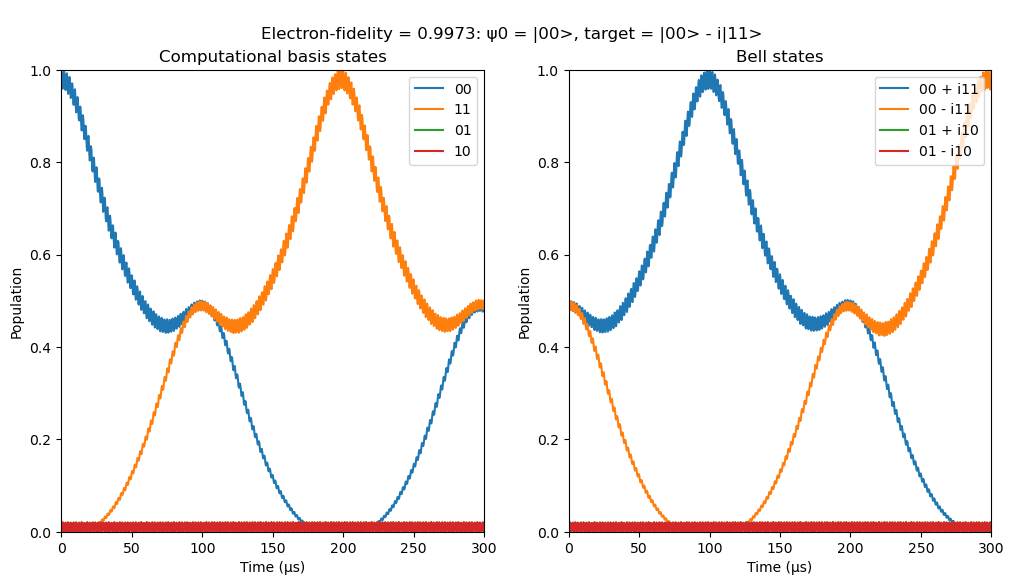

  0.327516 seconds (5.23 M allocations: 198.613 MiB, 13.23% gc time)


In [267]:
chamber = construct_two_ion_chamber(μ_I, μ_ν, μ_ν, μ_f_cl, μ_ϕ, MS_π2_TIME, B=B_STRENGTH, ac_correction=AC_CORRECTION);

ket0_vib_mode= IonSim.modes(chamber)[1][0] # ground state of first vibrational mode
dm0_vib_mode = dm(ket0_vib_mode)
ψ0 = ket_00 ⊗ ket0_vib_mode

h = hamiltonian(chamber_1, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ⊗ ket0_vib_mode, h);
ρ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(ρ_final, ρ_00_m_i11)), digits=4)
fig = plot_populations_double(chamber_1, tout00, sol00)
fig.suptitle("\nElectron-fidelity = $fid: ψ0 = |00>, target = |00> - i|11>")
plt.display(fig)
plt.close(fig)

## 1.b. RX, RY, RZ gate

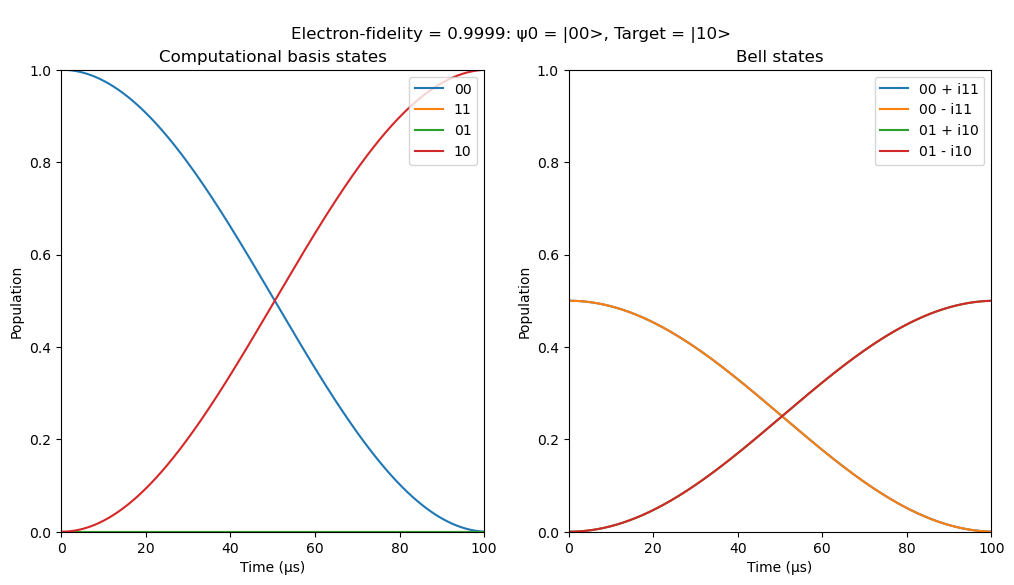

In [268]:
tout_RX, sol_RX = RX(chamber, 1, π, ket_00 ⊗ ket0_vib_mode, MS_π2_TIME);

ρ_final = ptrace(dm(sol_RX[end]), 3)
fid = round(real(fidelity(ρ_final, dm(ket_10))), digits=4)
fig = plot_populations_double(chamber, tout_RX, sol_RX)
fig.suptitle("\nElectron-fidelity = $fid: ψ0 = |00>, Target = |10>")
plt.display(fig)
plt.close(fig)

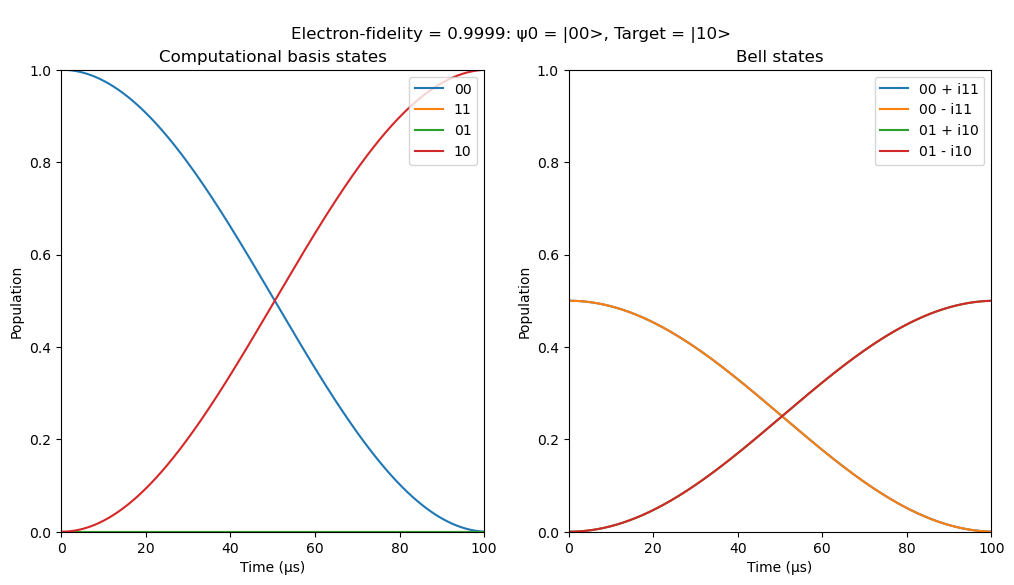

In [269]:
tout_RY, sol_RY = RY(chamber, 1, π, ket_00 ⊗ ket0_vib_mode, MS_π2_TIME);

ρ_final = ptrace(dm(sol_RY[end]), 3)
fid = round(real(fidelity(ρ_final, dm(ket_10))), digits=4)
fig = plot_populations_double(chamber, tout_RY, sol_RY)
fig.suptitle("\nElectron-fidelity = $fid: ψ0 = |00>, Target = |10>")
plt.display(fig)
plt.close(fig)

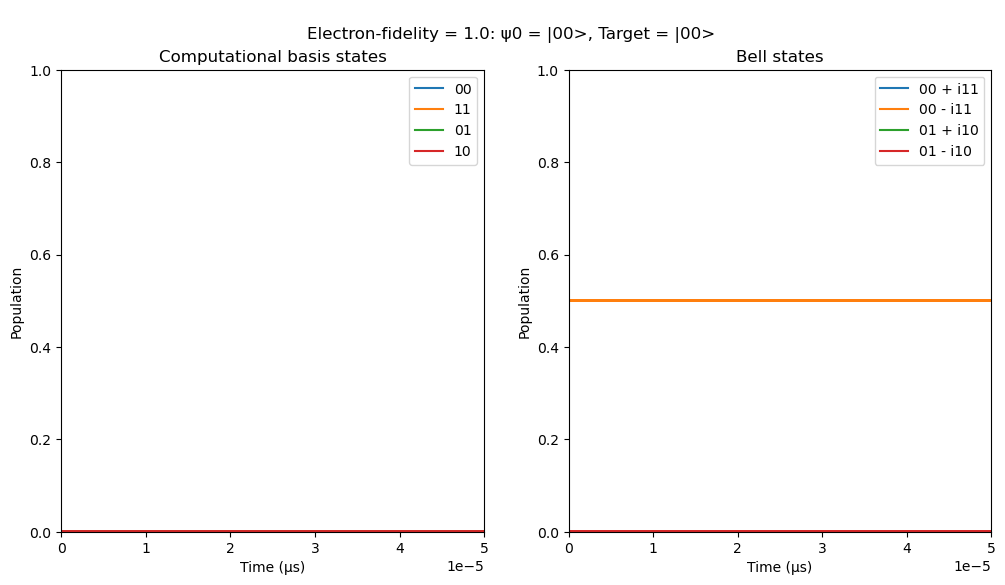

In [272]:
tout_RZ, sol_RZ = RZ(chamber, 1, π, ket_00 ⊗ ket0_vib_mode, MS_π2_TIME);

ρ_final = ptrace(dm(sol_RZ[end]), 3)
fid = round(real(fidelity(ρ_final, dm(ket_00))), digits=4)
fig = plot_populations_double(chamber, tout_RZ, sol_RZ)
fig.suptitle("\nElectron-fidelity = $fid: ψ0 = |00>, Target = |00>")
plt.display(fig)
plt.close(fig)